# Process Reddit comments

In [16]:
import csv
import datetime
import os
import pandas as pd
import pipes
import re
import sys
import tempfile
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from IPython.display import clear_output
from nltk.tokenize import TweetTokenizer

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
DATADIRIN = "../data/reddit/comments/"
DATADIROUT = "../data/reddit/text/"
DATEFORMATOUT = "%Y%m%d-%H"
SUBREDDIT = "subreddit"
CREATED = "created"
ID = "id"
AUTHOR = "author"
BODY = "body"
PARENT = "parent"
FILESUFFIX = ".out.gz"
IDSTR = "id_str"
REPLYID = "in_reply_to_status_id_str"
USER = "user"
VERIFIED = "verified"
TEXT = "text"
DELETED = "[deleted]"
REMOVED = "[removed]"

In [3]:
def squeal(text=None):
    clear_output(wait=True)
    if not text is None: print(text)

In [4]:
def makeDateString(date):
    return(datetime.datetime.strftime(datetime.datetime.fromtimestamp(date),DATEFORMATOUT))

In [5]:
def cleanup(text):
    text = re.sub(r"\\n"," ",text)
    text = re.sub(r"https://\S+","",text)
    text = re.sub(r"\s+"," ",text)
    text = text.strip()
    return(text)

def tokenize(text):
    return(" ".join(TweetTokenizer().tokenize(text)))

def preprocess(text):
    return(tokenize(cleanup(text)).lower())

## Language identification with langid

In [6]:
import langid

In [7]:
NL = "nl"
DE = "de"
AF = "af"

## Get all comments from crawled files

In [8]:
comments = []
files = sorted(os.listdir(DATADIRIN))
for i in range(0,len(files)):
    inFileName = files[i]
    squeal(" ".join([str(i),str(len(comments)),inFileName]))
    df = pd.read_csv(DATADIRIN+inFileName)
    for i in range(0,len(df)):
        date = df.iloc[i][CREATED]
        idStr = df.iloc[i][SUBREDDIT]+"_"+df.iloc[i][ID]
        parent = df.iloc[i][PARENT]
        user = df.iloc[i][AUTHOR]
        text = re.sub(r"\n"," ",df.iloc[i][BODY])
        if text == DELETED or text == REMOVED: continue
        preprocessedText = preprocess(text)
        language = langid.classify(preprocessedText)[0]
        if language in [NL,AF,DE]:
            comments.append((makeDateString(date),idStr,parent,user,None,text))
squeal(str(len(comments)))

52965


## Store all comments in hour files

In [11]:
idStr = ""
replyId = ""
verified = ""
dataPerHour = {}
for i in range(0,len(comments)):
    if i%1000 == 0: squeal(i)
    comment = comments[i]
    date = comment[0]
    user = comment[3]
    text = comment[5]
    if not date in dataPerHour: dataPerHour[date] = []
    dataPerHour[date].append({IDSTR:idStr,REPLYID:replyId,USER:user,VERIFIED:verified,TEXT:text})
squeal(i)

52964


In [12]:
for date in sorted(dataPerHour.keys()):
    squeal(date)
    outFileName = DATADIROUT+date+FILESUFFIX
    pd.DataFrame(dataPerHour[date]).to_csv(outFileName,index=False,compression="gzip")

In [13]:
commentsDays = []
for comment in comments:
    comment = list(comment)
    comment[0] = comment[0][:8]
    commentsDays.append(comment)

In [14]:
df = pd.DataFrame(commentsDays)
groups = df.groupby(0).groups
dates = {f:len(groups[f]) for f in groups}

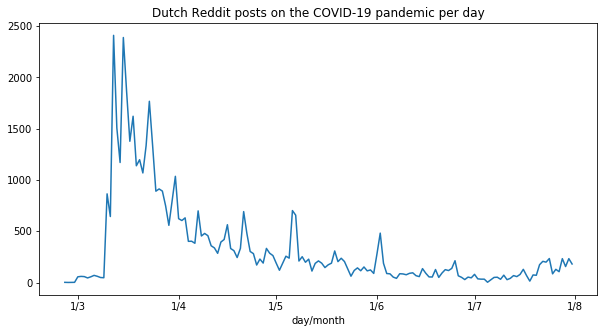

In [21]:
DATEFORMATDAY = "%Y%m%d"
PLOTFILENAME = "frequency-reddit.png"

x = [datetime.datetime.strptime(d,DATEFORMATDAY) for d in dates if d < "20200801"]
y = [dates[d] for d in dates if d < "20200801"]

plt.subplots(figsize=(10,5))
ax = plt.subplot(111)
plt.plot_date(x,y,fmt="-")
plt.xlabel("day/month")
ax.xaxis.set_major_formatter(mdates.DateFormatter("%-d/%-m"))
plt.title("Dutch Reddit posts on the COVID-19 pandemic per day")
plt.savefig(PLOTFILENAME)
plt.show()